In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from pmdarima.model_selection import train_test_split

import os
import sys

from arch import arch_model
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# stock_path = './Dataset/Stocks/'
stock_path = './Stocks_dow/'
img_path = './Images/'
DJ_path = './Dataset/Dow Jones/'
rf_path = './Dataset/US1M/'

In [10]:
class Strategy():
    def __init__(self, stock_path, train_start, train_end, test_start, test_end):
        self.stock_path = stock_path
        self.stock_list = os.listdir(stock_path)
        self.stock_list = [stock for stock in self.stock_list if stock.endswith('.csv')]  # filter out the csv files

        # time
        self.train_start = train_start
        self.train_end = train_end
        self.test_start = test_start
        self.test_end = test_end

        # price/volume data
        self.high = self.extract_data('High', train_start, test_end).reindex(pd.date_range(train_start, test_end, freq='W-FRI')).ffill()
        self.low = self.extract_data('Low', train_start, test_end).reindex(pd.date_range(train_start, test_end, freq='W-FRI')).ffill()
        self.open = self.extract_data('Open', train_start, test_end).reindex(pd.date_range(train_start, test_end, freq='W-FRI')).ffill()
        self.close = self.extract_data('Close', train_start, test_end).reindex(pd.date_range(train_start, test_end, freq='W-FRI')).ffill()
        self.volume = self.extract_data('Volume', train_start, test_end).reindex(pd.date_range(train_start, test_end, freq='W-FRI')).ffill()
        self.adjclose = self.extract_data('Adj Close', train_start, test_end).reindex(pd.date_range(train_start, test_end, freq='W-FRI')).ffill()

        # Dow Jones Index
        self.dj_index = pd.read_csv(DJ_path + 'DIA.csv')
        self.dj_index['Date'] = pd.to_datetime(self.dj_index['Date'])
        self.dj_index.set_index('Date', inplace=True)
        self.dj_index = self.dj_index.reindex(pd.date_range(train_start, test_end, freq='W-FRI')).ffill()

        # risk-free rate
        self.rf = pd.read_csv(rf_path + 'DGS1MO.csv')
        self.rf['DATE'] = pd.to_datetime(self.rf['DATE'])
        self.rf.set_index('DATE', inplace=True)
        self.rf = self.rf.replace('.', np.nan).reindex(self.adjclose.index, method='ffill').astype(float) / 100
        self.rf = self.rf.reindex(pd.date_range(train_start, test_end, freq='W-FRI')).ffill()

        # train/test data
        self.train_data = self.adjclose[(self.adjclose.index >= self.train_start) & (self.adjclose.index <= self.train_end)]
        self.test_data = self.adjclose[(self.adjclose.index >= self.test_start) & (self.adjclose.index <= self.test_end)]
        self.test_data = pd.concat([self.train_data.iloc[-1:], self.test_data], axis=0)
        self.dj_train = self.dj_index[(self.dj_index.index >= self.train_start) & (self.dj_index.index <= self.train_end)]
        self.dj_test = self.dj_index[(self.dj_index.index >= self.test_data.index[0]) & (self.dj_index.index <= self.test_end)]
        self.rf_train = self.rf[(self.rf.index >= self.train_start) & (self.rf.index <= self.train_end)]
        self.rf_test = self.rf[(self.rf.index >= self.test_data.index[0]) & (self.rf.index <= self.test_end)]
        
        # models
        self.scaler = None; self.pca = None; self.garch_model = None
        # daily return
        self.train_return = None; self.test_return = None
        # standardized return
        self.scaled_train = None; self.scaled_test = None
        # principal components
        self.pc_train = None; self.pc_test = None
        # market index
        self.train_index = None; self.test_index = None
        # weights
        self.weights_pc = None  # weights of each PC
        self.weights_stock = None  # weights of stocks in the index
        self.weight_stockpool = None  # investment weights in the stock pool in the prediction period
        self.optimal_weights_stock = None   # weights of stocks in the tangency portfolio

        self.forecast_var = None
        self.forecast_return = None

        self.tangency_return = None


    # =========================================================================
    # Data Tool
    # =========================================================================
    def extract_data(self, variable, start_date, end_date):
        '''
        extract specific data from our dataset
        '''
        for stock in self.stock_list:
            data = pd.read_csv(stock_path + stock)
            data['Date'] = pd.to_datetime(data['Date'])
            data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
            data = data[['Date', variable]]
            data = data.rename(columns={variable: stock[:-4]})
            if stock == self.stock_list[0]:
                df = data
            else:
                df = pd.merge(df, data, on='Date', how='left')
        df.set_index('Date', inplace=True)
        return df
    
    def drop_stock(self):
        '''
        drop stock which has missing values
        '''
        self.adjclose = self.adjclose.dropna(axis=1)
        self.stock_list = self.adjclose.columns.tolist()
        self.high = self.high[self.stock_list]
        self.low = self.low[self.stock_list]
        self.open = self.open[self.stock_list]
        self.close = self.close[self.stock_list]
        self.volume = self.volume[self.stock_list]

        self.train_data = self.adjclose[(self.adjclose.index >= self.train_start) & (self.adjclose.index <= self.train_end)]
        self.test_data = self.adjclose[(self.adjclose.index >= self.test_start) & (self.adjclose.index <= self.test_end)]
        self.test_data = pd.concat([self.train_data.iloc[-1:], self.test_data], axis=0)

    
    # =========================================================================
    # Market Index
    # =========================================================================
    def pca_analysis(self, n_components=10, save=False):
        '''
        PCA analysis for the stock market index
        : return: cumulative explained variance ratio
        '''
        # calculate the return
        self.train_return = self.train_data.pct_change().dropna()
        self.test_return = self.test_data.pct_change().dropna()

        # data standardization
        self.scaler = StandardScaler()
        # self.scaled_train = self.scaler.fit_transform(self.train_data)
        # self.scaled_train = pd.DataFrame(self.scaled_train, index=self.train_data.index, columns=self.train_data.columns)
        self.scaled_train = self.scaler.fit_transform(self.train_return)
        self.scaled_train = pd.DataFrame(self.scaled_train, index=self.train_return.index, columns=self.train_return.columns)

        # PCA analysis
        pca = PCA(n_components=n_components)
        pca.fit(self.scaled_train)

        # explained variance ratio
        explained_variance_ratio = pca.explained_variance_ratio_

        if save:
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, n_components + 1), explained_variance_ratio, marker='o', color='skyblue')
            plt.xlabel('Principal Component')
            plt.ylabel('Explained Variance Ratio')
            plt.title('Explained Variance Ratio of Principal Components')
            plt.grid(linestyle='--', alpha=0.3)
            plt.savefig(img_path + 'explained_variance_ratio.png')

        return explained_variance_ratio.cumsum()
    
    def stock_weights(self, n_components=3, plot=True):
        '''
        compute the weights of each stock in the market index
        '''
        self.pca = PCA(n_components=n_components)
        self.pca.fit(self.scaled_train)

        # compute weight of each PC
        self.weights_pc = self.pca.explained_variance_ratio_
        self.weights_pc = self.weights_pc / self.weights_pc.sum()

        # compute the stock weights
        loadings = self.pca.components_.T  # loadings of each stock on each PC
        loadings_df = pd.DataFrame(loadings, index=self.stock_list, columns=['PC'+str(i) for i in range(1, n_components+1)])
        # weighted average of loadings
        loadings_df['Weighted Loadings'] = np.abs(np.sum(loadings_df * self.weights_pc, axis=1))
        # normalize the weighted loadings
        self.weights_stock = loadings_df['Weighted Loadings'] / np.sum(loadings_df['Weighted Loadings'])

        if plot:
            stock_weights = self.weights_stock.sort_values(ascending=False)
            plt.figure(figsize=(8, 8))
            plt.pie(stock_weights, labels=stock_weights.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues'))
            plt.title('Stock Weights in the Market Index')

        return self.weights_stock
    
    # =========================================================================
    # Volatility Prediction
    # =========================================================================
    def volatility_prediction(self, mean='Constant'):
        '''
        predict the volatility of the market index (GARCH model)
        : return: model summary & forecast
        '''
        pred_horizon = self.test_data.shape[0] - 1  # prediction horizon

        stock_return = 100 * self.train_data.pct_change().dropna()

        params = {}
        pvalues = {}
        forcast = {}

        for stock in self.stock_list:
            garch_model = arch_model(stock_return[stock], mean=mean, vol='Garch', p=1, q=1)
            garch_model = garch_model.fit(disp='off')
            params[stock] = garch_model.params
            pvalues[stock] = garch_model.pvalues
            forecast = garch_model.forecast(horizon=pred_horizon)
            forcast[stock] = forecast.variance.iloc[-1].values

        params_df = pd.DataFrame(params).T
        pvalues_df = pd.DataFrame(pvalues).T
        self.forecast_var = pd.DataFrame(forcast).T.rename(columns={0: f'{self.test_data.index[-1].strftime("%Y-%m-%d")}'})

        return params_df, pvalues_df, self.forecast_var
    

    def market_volatility(self):
        market_index_volatility = np.zeros((len(self.forecast_var.columns), 1))
        corr = self.train_return.corr()
        # go through each forecast
        for i, col in enumerate(self.forecast_var.columns):
            self.weighted_vol = self.weights_stock.values * self.forecast_var[col]
            market_index_volatility[i] = np.sqrt(np.dot(np.dot(self.weighted_vol.values.T, corr), self.weighted_vol.values))
        market_index_volatility = pd.DataFrame(market_index_volatility) / 100
        self.forcast_mktvol = market_index_volatility
        return market_index_volatility
    

    # =========================================================================
    # Stock Return Prediction
    # =========================================================================
    def return_prediction(self):
        '''
        Predict returns using ARIMA model
        :return: model summary & forecasts
        '''
        # Define your prediction horizon
        pred_horizon = self.test_data.shape[0] -1 

        # Calculate stock returns
        stock_return = self.train_data.pct_change().dropna()

        # Initialize dictionaries to store parameters, p-values, and forecasts
        params = {}
        pvalues = {}
        forecasts = {}

        # Iterate over each stock
        for stock in self.stock_list:
            # Fit ARIMA model
            arima_model = pm.auto_arima(stock_return[stock], seasonal=False)
            # Store parameters
            params[stock] = arima_model.get_params()
            # Store p-values
            p_values = arima_model.pvalues()
            # print("*****", p_values)
            pvalues[stock] = p_values
            # Make forecasts
            forecast = arima_model.predict(n_periods=pred_horizon)
            # Store forecasts
            forecasts[stock] = forecast

        # Convert dictionaries to DataFrames
        params_df = pd.DataFrame(params).T
        pvalues_df = pvalues
        self.forecast_return = pd.DataFrame(forecasts).T

        return params_df, pvalues_df, self.forecast_return


    # =========================================================================
    # Tangency Portfolio Calculation
    # =========================================================================
    def tangency_portfolio(self):
        '''
        calculate the tangency portfolio
        '''
        # correlation matrix
        corr = self.train_return.corr()
        # covariance matrix
        forecast_vol = np.sqrt(self.forecast_var) / 100
        cov = np.dot(np.dot(np.diag(forecast_vol.values.flatten()), corr), np.diag(forecast_vol.values.flatten()))

        rf_rate = self.rf_train.iloc[-1:].mean().values[0] / 52
        excess_return = self.forecast_return - rf_rate

        # target function
        def negative_sharpe_ratio(weights):
            returns = np.dot(weights, excess_return)
            volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
            sharpe_ratio = returns / volatility
            return -sharpe_ratio
        
        constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
        bounds = tuple((-1, 1) for _ in range(len(excess_return)))  # set the bounds of the weights [-1,1]

        initial_weights = np.array(len(excess_return) * [1. / len(excess_return)])
        result = minimize(negative_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
        optimal_weights = result.x
        self.optimal_weights_stock = pd.Series(optimal_weights, index=self.stock_list)

        # calculate the return of the tangency portfolio
        self.tangency_return = (self.optimal_weights_stock * self.test_return).sum().sum()


        return self.optimal_weights_stock, self.tangency_return

    
    # =========================================================================
    # Strategy
    # =========================================================================
    def strategy_1(self, h=0.5, _lambda=1):
        '''
        fixed function: market vol -> weights
        '''
        def weight_func(x, _lambda=_lambda):
            return (1 + h) * np.exp(-_lambda * x) / (h + np.exp(-_lambda * x))
        
        self.weight_stockpool = weight_func(self.forcast_mktvol)
        # self.weight_stockpool = (1 + h) * np.exp(-_lambda * self.forcast_mktvol) / (h + np.exp(-_lambda * self.forcast_mktvol))
        self.weight_stockpool.index = self.test_data.iloc[1:].index

        return self.weight_stockpool

    def strategy_2(self):
        pass        
        

    # =========================================================================
    # Performance Evaluation
    # =========================================================================
    def perf_eval(self):
        '''
        calculate the performance of the strategy
        '''
        # portfolio return
        dj_return = self.dj_test['Adj Close'].pct_change().dropna()
        portfolio_return = self.weight_stockpool.values.flatten() * dj_return  + \
            (1 - self.weight_stockpool.values.flatten())  * self.rf_test.iloc[1:].mean().values[0] / 252
        # self.weight_stockpool * dj_return + (1 - self.weight_stockpool) * self.rf_test.iloc[1:].mean() / 252
        portfolio_cum_return = (portfolio_return + 1).cumprod()
        # portfolio_nav = pd.Series(np.insert(portfolio_cum_return, 0, 1), index=self.test_data.index) * self.dj_test['Adj Close'].iloc[0]

        

        eval_sheet = pd.DataFrame({'Return': [portfolio_cum_return.iloc[-1], 
                                                      self.dj_test['Adj Close'].iloc[-1] / self.dj_test['Adj Close'].iloc[0] - 1]},
                                  index=['Portfolio', 'DIA'])

        return self.dj_test['Adj Close'], eval_sheet     
    

    # =========================================================================
    # Visualization Tool
    # =========================================================================
    def vis_nan(self):
        '''
        visualize the missing values in the dataset
        '''
        # the nan number of each column & plot
        nan_num = self.adjclose.isnull().sum() / self.adjclose.shape[0]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=nan_num.index, y=nan_num.values, color='skyblue')
        plt.xticks(rotation=90)
        plt.xlabel('Stock')
        plt.title('Missing Value Proportion of Each Stock')
        plt.grid(linestyle='--', alpha=0.3)
        # label the non-zero value
        for i, v in enumerate(nan_num):
            if v > 0:
                plt.text(i, v, round(v, 2), ha='center', va='bottom', fontsize=8)
        plt.savefig(img_path + 'missing_value_proportion.png')

In [16]:
#pd.read_pickle('forecast_return_2012-01-20.pkl')

,2022-01-14
CSCO,0.003265
BA,-0.003213
V,0.005093
MRK,-0.002998
PG,-0.002358
CAT,0.002654
MCD,0.004089
AMZN,0.006253
INTC,0.002559
MMM,0.002431


In [14]:
model.train_data

""
2012-04-06
2012-04-13
2012-04-20
2012-04-27
2012-05-04
...
2022-02-25
2022-03-04
2022-03-11
2022-03-18


In [4]:
train_start = pd.to_datetime('2013-08-11')
train_end = train_start + pd.DateOffset(weeks=520)
test_start = train_end + pd.DateOffset(days=3)
test_end = train_end + pd.DateOffset(days=9)

print('Train Period:', train_start, 'to', train_end)
print('Test Period:', test_start, 'to', test_end)

model = Strategy(stock_path, train_start, train_end, test_start, test_end)

Train Period: 2013-08-11 00:00:00 to 2023-07-30 00:00:00
Test Period: 2023-08-02 00:00:00 to 2023-08-08 00:00:00


stock number: 30


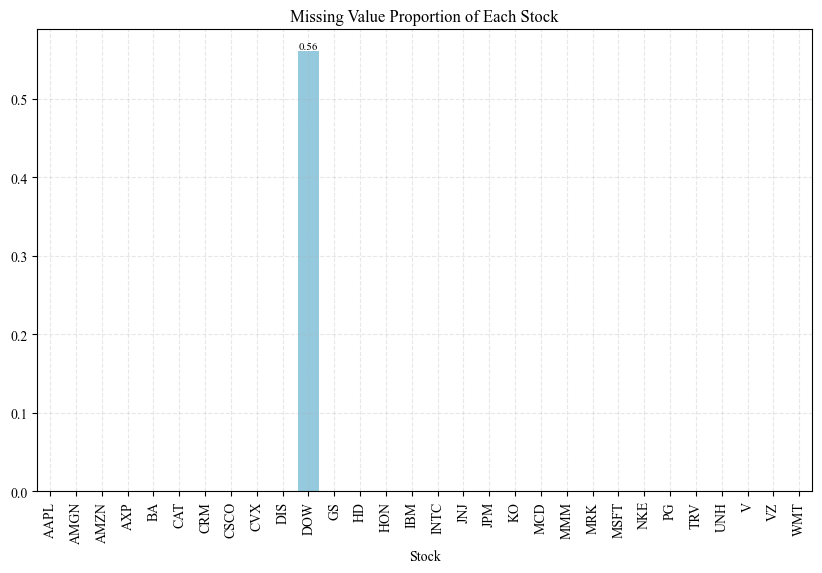

In [273]:
print('stock number:', len(model.stock_list))
model.vis_nan()   # we will not use DOW in our portfolio

In [274]:
model.drop_stock()   # according to the above figure, some stocks have too many missing values, so we drop them
print('stock number:', len(model.stock_list))

stock number: 29


In [275]:
model.pca_analysis()   # PCA analysis

array([0.44918353, 0.514017  , 0.57695848, 0.61585593, 0.64909249,
       0.6759143 , 0.69958986, 0.72158483, 0.7429897 , 0.7638804 ])

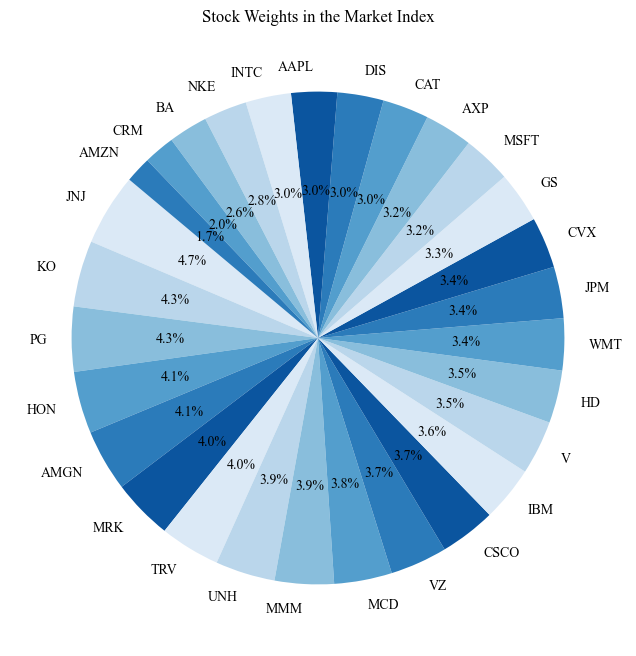

In [276]:
stock_weights = model.stock_weights(3, True)  # compute the weights of each stock in the market index

In [277]:
params_df, pvalues_df, forecast = model.volatility_prediction()  # volatility prediction
pvalues_df
print(forecast.shape)

(29, 1)


In [278]:
model.market_volatility()  # market volatility

,0
0,0.074002


In [279]:
r_params, r_pvalues, r_forecast = model.return_prediction()

In [282]:
weights, portreturn = model.tangency_portfolio()
print('Tangency Portfolio Return:', portreturn)

Tangency Portfolio Return: 0.0024307875965575544


In [283]:
model.strategy_1(h=0.01, _lambda=0.25)

,0
2023-08-04,0.999815


In [284]:
nav, dj_nav, eval_sheet = model.perf_eval()
print(eval_sheet)

             Return
Portfolio -0.010802
DIA       -0.010805


## Strategy: Weekly Adjustment

In [7]:
start_time_list

DatetimeIndex(['2012-01-06', '2012-01-13', '2012-01-20', '2012-01-27',
               '2012-02-03', '2012-02-10', '2012-02-17', '2012-02-24',
               '2012-03-02', '2012-03-09', '2012-03-16', '2012-03-23',
               '2012-03-30', '2012-04-06', '2012-04-13', '2012-04-20',
               '2012-04-27', '2012-05-04', '2012-05-11', '2012-05-18',
               '2012-05-25'],
              dtype='datetime64[ns]', freq='W-FRI')

In [20]:
# 2012-01-01 ~ 2013-12-31 freq='W-FRI'
# start_time_list = pd.date_range(start='2012-01-01', end='2013-12-31', freq='W-FRI')
start_time_list = pd.date_range(start='2013-03-30', end='2013-05-31', freq='W-FRI')

# h, _lambda
control_params = [(0.001, 35), (0.001, 40), (0.001, 45), (0.001, 50), (0.001, 55)]

DIA_return_list = {x: [] for x in control_params}
tangency_return_list = []
multiast_return_list = {x: [] for x in control_params}
market_return_list = []  # for DIA ETF

for i in range(len(start_time_list)):
    print('Start Time:', start_time_list[i])
    train_start = start_time_list[i]
    train_end = train_start + pd.DateOffset(weeks=520)
    test_start = train_end + pd.DateOffset(days=3)
    test_end = train_end + pd.DateOffset(days=9)

    model = Strategy(stock_path, train_start, train_end, test_start, test_end)
    model.drop_stock()
    vol_prop = model.pca_analysis()
    stock_w = model.stock_weights(3, False)
    params, pvalues, fore = model.volatility_prediction()  # volatility prediction
    pred_vol = model.market_volatility()
    r_params, r_pvalues, r_forecast = model.return_prediction()
    r_forecast.to_pickle(f'forecast_return_{start_time_list[i].strftime("%Y-%m-%d")}.pkl')
    weights, tang_return = model.tangency_portfolio()
    tangency_return_list.append(tang_return)

    for i, param in enumerate(control_params):
        index_w = model.strategy_1(h=param[0], _lambda=param[1])
        dj_nav, eval_sheet = model.perf_eval()
        DIA_return_list[param].append(eval_sheet.loc['Portfolio', 'Return'])
        if i == 0:
            market_return_list.append(eval_sheet.loc['DIA', 'Return'])
        multiast_return = index_w * tang_return + (1 - index_w) * model.rf_train.iloc[-1:].mean().values[0] / 52
        multiast_return_list[param].append(multiast_return.values[0][0])


# test_start_time_list = start_time_list + 10 years
test_start_time_list = start_time_list + pd.DateOffset(years=10)
DIA_return_list = pd.DataFrame(DIA_return_list, index=test_start_time_list)
tangency_return_list = pd.DataFrame(tangency_return_list, index=test_start_time_list)
multiast_return_list = pd.DataFrame(multiast_return_list, index=test_start_time_list)
market_return_list = pd.Series(market_return_list, index=test_start_time_list)

Start Time: 2013-04-05 00:00:00
Start Time: 2013-04-12 00:00:00
Start Time: 2013-04-19 00:00:00
Start Time: 2013-04-26 00:00:00
Start Time: 2013-05-03 00:00:00
Start Time: 2013-05-10 00:00:00
Start Time: 2013-05-17 00:00:00
Start Time: 2013-05-24 00:00:00
Start Time: 2013-05-31 00:00:00


In [17]:
pd.date_range(start='2012-04-07', end='2012-05-31', freq='W-FRI')

DatetimeIndex(['2012-04-13', '2012-04-20', '2012-04-27', '2012-05-04',
               '2012-05-11', '2012-05-18', '2012-05-25'],
              dtype='datetime64[ns]', freq='W-FRI')

In [9]:
np.insert(portfolio_cum_return, 0, 1)

NameError: name 'portfolio_cum_return' is not defined

In [323]:
# DIA_return_list.iloc[:, 0]

2022-01-06    0.027105
2022-01-13   -0.002751
2022-01-20   -0.008625
2022-01-27   -0.045428
Name: (0.001, 35), dtype: float64

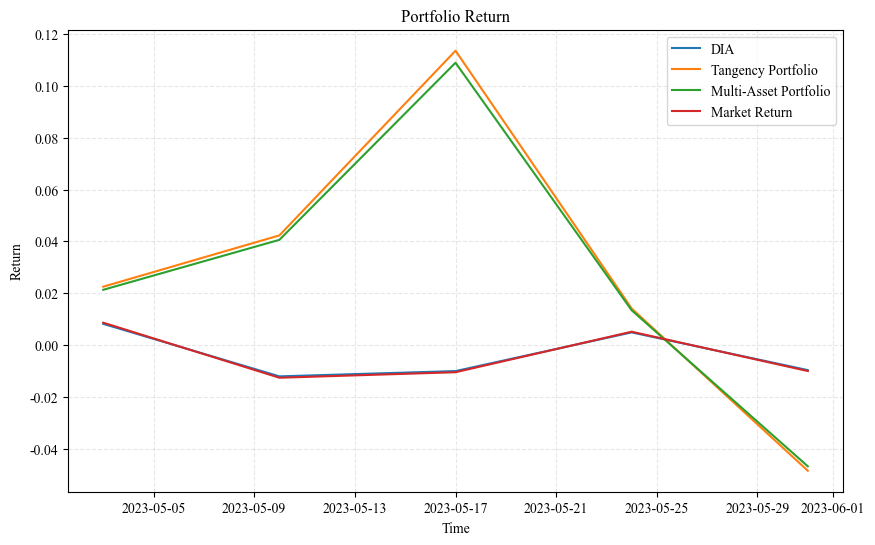

In [331]:
# plot
plt.figure(figsize=(10, 6))
plt.plot(DIA_return_list.index, DIA_return_list.iloc[:, -1], label='DIA')
plt.plot(DIA_return_list.index, tangency_return_list, label='Tangency Portfolio')
plt.plot(DIA_return_list.index, multiast_return_list.iloc[:, -1], label='Multi-Asset Portfolio')
plt.plot(DIA_return_list.index, market_return_list, label='Market Return')
plt.xlabel('Time')
plt.ylabel('Return')
plt.title('Portfolio Return')
plt.legend()
plt.grid(linestyle='--', alpha=0.3)
plt.show()

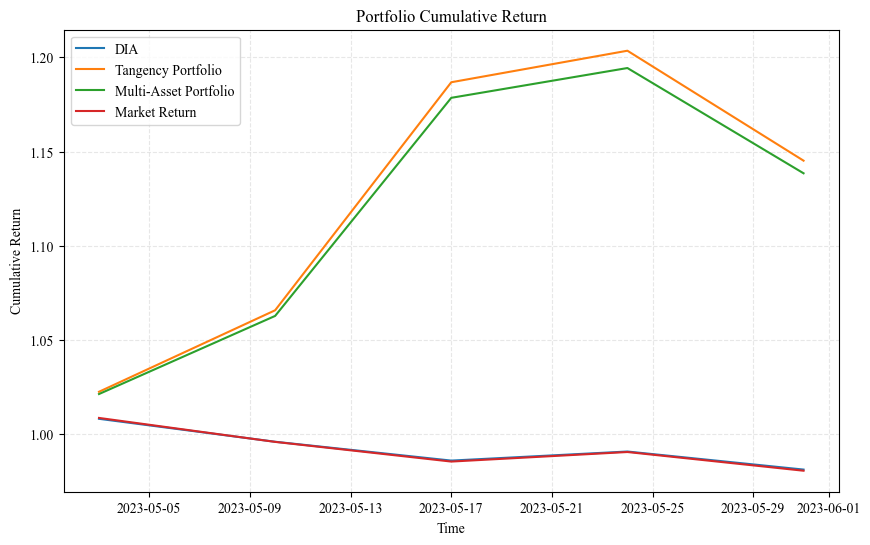

In [332]:
# cumulative return
plt.figure(figsize=(10, 6))
plt.plot(DIA_return_list.index, (1 + DIA_return_list.iloc[:, -1]).cumprod(), label='DIA')
plt.plot(DIA_return_list.index, (1 + tangency_return_list).cumprod(), label='Tangency Portfolio')
plt.plot(DIA_return_list.index, (1 + multiast_return_list.iloc[:, -1]).cumprod(), label='Multi-Asset Portfolio')
plt.plot(DIA_return_list.index, (1 + market_return_list).cumprod(), label='Market Return')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.title('Portfolio Cumulative Return')
plt.legend()
plt.grid(linestyle='--', alpha=0.3)
plt.show()